In [1]:
using DrWatson
@quickactivate "Research"

In [2]:
using LinearAlgebra, Statistics, Distances, VecTarget, AdvancedHMC, CoupledHMC
using Plots, LaTeXStrings

dim = 2
target = get_target(HighDimGaussian(dim))
q₀ = [
    0.5  0.5;
    2.5 -1.0
]
metric = UnitEuclideanMetric((dim, 2))
hamiltonian = Hamiltonian(metric, target.logdensity, target.get_grad(q₀))
integrator = Leapfrog(fill(0.3, 2))

p₀ = ones(2)
z = AdvancedHMC.phasepoint(hamiltonian, q₀, cat(p₀, p₀; dims=2))
zs = [z, AdvancedHMC.step(integrator, hamiltonian, z, 7; fwd=true, full_trajectory=Val(true))...]

ℓweights = -AdvancedHMC.energy.(zs)
ℓweights = cat(ℓweights...; dims=2)
unnorm_ℓprob = ℓweights
prob = exp.(unnorm_ℓprob .- AdvancedHMC.logsumexp(unnorm_ℓprob; dims=2))

τ¹ = cat(map(z -> z.θ[:,1], zs)...; dims=2)
τ² = cat(map(z -> z.θ[:,2], zs)...; dims=2)
p, q = prob[1,:], prob[2,:]

# Here's a hand-crafted toy example - comment it out to try!
# τ¹ = reshape([100, 74, 94, 19, 73], 1, :)
# τ² = reshape([ 74, 83, 35, 66, 57], 1, :)
# p = [0.15, 0.42, 0.14, 0.21, 0.08]
# q = [0.52, 0.12, 0.18, 0.16, 0.02]

┌ Info: Precompiling VecTarget [8a639fad-7908-4fe4-8003-906e9297f002]
└ @ Base loading.jl:1278
┌ Info: Precompiling CoupledHMC [2b235a6e-c7ff-4bf8-b98e-bb5eae5895d5]
└ @ Base loading.jl:1278
┌ Info: Skipping precompilation since __precompile__(false). Importing CoupledHMC [2b235a6e-c7ff-4bf8-b98e-bb5eae5895d5].
└ @ Base loading.jl:1034


([0.1224135787389357, 0.12059944993460205, 0.12049575923934241, 0.12213506239845574, 0.12499307612653697, 0.12810719137658427, 0.1303593147832558, 0.1308965674022868], [0.12546722946599762, 0.1257731488246476, 0.12577347553212598, 0.12546809251759505, 0.12496608334910153, 0.12444525936666462, 0.12408810954710119, 0.12401860139676675])

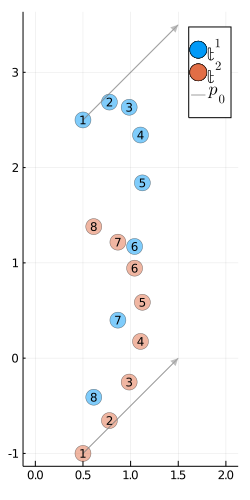

In [3]:
function vis_τ(τ¹, τ², p₀; figsize=(250, 500))
    fig = plot(size=figsize, aspect_ratio=1, legendmarkersize=1, legendfontsize=12)
    scatter!(fig, τ¹[1,:], τ¹[2,:]; label=L"\mathbb{t}^1", alpha=0.5, markersize=9)
    scatter!(fig, τ²[1,:], τ²[2,:]; label=L"\mathbb{t}^2", alpha=0.5, markersize=9)
    plot!(
        fig, [τ¹[1,1], τ¹[1,1] + p₀[1]], [τ¹[2,1], τ¹[2,1] + p₀[2]]; 
        label=L"p_0", arrow=arrow(:closed), alpha=0.5, c=:gray
    )
    plot!(
        fig, [τ²[1,1], τ²[1,1] + p₀[1]], [τ²[2,1], τ²[2,1] + p₀[2]]; 
        label=nothing, arrow=arrow(:closed), alpha=0.5, c=:gray
    )
    annotate!([(τ¹[1,i], τ¹[2,i], Plots.text("$i", 8, :black, :center)) for i in 1:size(τ¹, 2)])
    annotate!([(τ²[1,i], τ²[2,i], Plots.text("$i", 8, :black, :center)) for i in 1:size(τ², 2)])
    fig
end

fig_τ = vis_τ(τ¹, τ², p₀)

savefig(fig_τ, plotsdir("illustration", "trajectories.png"))
savefig(fig_τ, plotsdir("illustration", "trajectories.pdf"))

fig_τ

In [23]:
Base.count(idcs, K::Int) = [count(idx -> idx == k, idcs) for k in 1:K]

expdistance_of(samples) = mean(s -> norm(s.x - s.y), samples)

W2_of(samples) = sqrt(mean(s -> norm(s.x - s.y).^2, samples))

function stats_of(idxpair, p, q, τ¹, τ²)
    M, N = length(p), length(q)
    count_i = count(map(ip -> ip.i, idxpair), M)
    p̂ = count_i / length(idxpair)
    count_j = count(map(ip -> ip.j, idxpair), N)
    q̂ = count_j / length(idxpair)
    samples = map(ip -> (x = τ¹[:,ip.i], y = τ²[:,ip.j]), idxpair)
    return (
        p̂ = round.(p̂; digits=2),
        q̂ = round.(q̂; digits=2),
        kl_p = kl_divergence(p, p̂),
        kl_q = kl_divergence(q, q̂),
        W1 = expdistance_of(samples),
        W2 = W2_of(samples),
    )
end

ic = IndependentCoupling(p, q)
@time idxpair_ic = [rand(ic) for _ in 1:100_000]

@info "Independent Coupling" stats_of(idxpair_ic, p, q, τ¹, τ²)...

  0.070822 seconds (365.03 k allocations: 35.432 MiB)


┌ Info: Independent Coupling
│   p̂ = [0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13]
│   q̂ = [0.12, 0.12, 0.13, 0.13, 0.12, 0.12, 0.13, 0.12]
│   kl_p = 3.1978240873883554e-5
│   kl_q = 7.495327444998509e-5
│   W1 = 1.6605074269305693
│   W2 = 1.918355320859273
└ @ Main In[23]:27


In [24]:
qc = QuantileCoupling(p, q)
@time idxpair_qc = [rand(qc) for _ in 1:100_000]

@info "Quantile Coupling" stats_of(idxpair_qc, p, q, τ¹, τ²)...

  4.270209 seconds (2.07 M allocations: 3.757 GiB, 17.53% gc time)


┌ Info: Quantile Coupling
│   p̂ = [0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13]
│   q̂ = [0.12, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12, 0.12]
│   kl_p = 3.071219045026183e-5
│   kl_q = 1.288075768561817e-5
│   W1 = 1.9904544677407678
│   W2 = 2.2813982361862823
└ @ Main In[24]:4


In [25]:
mc = MaximalCoupling(p, q)
@time idxpair_mc = [rand(mc) for _ in 1:100_000]

@info "Maximal Coupling" stats_of(idxpair_mc, p, q, τ¹, τ²)...

  0.077630 seconds (471.53 k allocations: 50.058 MiB)


┌ Info: Maximal Coupling
│   p̂ = [0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13]
│   q̂ = [0.13, 0.13, 0.13, 0.12, 0.13, 0.12, 0.12, 0.13]
│   kl_p = 6.348481074975644e-5
│   kl_q = 5.922709104339767e-5
│   W1 = 1.9743178149199876
│   W2 = 2.269997509211752
└ @ Main In[25]:4


In [26]:
otc = OTCoupling(p, q, τ¹, τ²)
@time idxpair_otc = [rand(otc) for _ in 1:100_000]

@info "OT Coupling" stats_of(idxpair_otc, p, q, τ¹, τ²)...

 10.314394 seconds (6.27 M allocations: 596.194 MiB, 2.14% gc time)


┌ Info: OT Coupling
│   p̂ = [0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13]
│   q̂ = [0.12, 0.13, 0.13, 0.12, 0.13, 0.12, 0.12, 0.12]
│   kl_p = 4.4393368691697066e-5
│   kl_q = 4.7641817501681e-5
│   W1 = 1.3196575919780333
│   W2 = 1.3730571530410776
└ @ Main In[26]:4


In [27]:
aotc = ApproximateOTCoupling(p, q, τ¹, τ²)
@time idxpair_aotc = [rand(aotc) for _ in 1:100_000]

@info "Approximate OT Coupling" stats_of(idxpair_aotc, p, q, τ¹, τ²)...

  5.618018 seconds (3.27 M allocations: 522.187 MiB, 1.89% gc time)


┌ Info: Approximate OT Coupling
│   p̂ = [0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13]
│   q̂ = [0.13, 0.13, 0.13, 0.12, 0.13, 0.12, 0.12, 0.12]
│   kl_p = 4.05141122712541e-5
│   kl_q = 1.4032356809348429e-5
│   W1 = 1.3288833830922138
│   W2 = 1.3962913024408392
└ @ Main In[27]:4


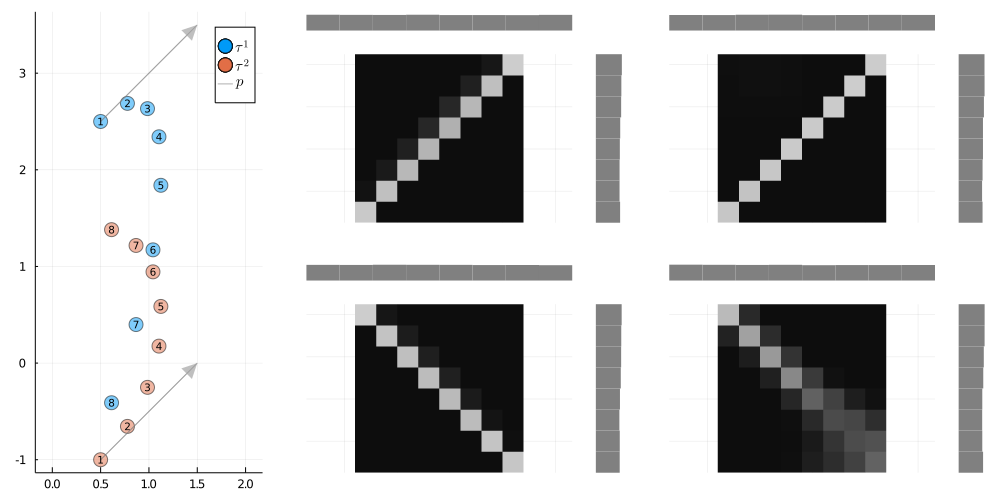

In [9]:
function jointmat_by(idxpair, M, N)
    J = zeros(Int, M, N)
    for ip in idxpair
        J[ip.i,ip.j] += 1
    end
    return J / sum(J)
end

function vis_γ(idxpair, p, q; rescale=1, size=(300, 300), showlabel=false)
    M, N = length(p), length(p)
    J = jointmat_by(idxpair, M, N)
    @assert (1 / rescale) < (1 / maximum(J)) "Cannot rescale to hide historgram."
    J = J / rescale
    p̂, q̂ = vec(sum(J; dims=2)), vec(sum(J; dims=1))
    
    layout = @layout [
        tophist           _
        hist2d{0.9w,0.9h} righthist
    ]
    fig = plot(; size=size, layout=layout)
    kwlabels = showlabel ? (xlabel = L"\mathbf{q}", ylabel = L"\mathbf{p}") : ()
    heatmap!(
        fig, 1:M, 1:N, J; 
        showaxis=false, aspect_ratio=1, clims=(0, 1), colorbar=nothing, subplot=2, c=:grays,
        kwlabels...
    )
    bar!(
        fig, q̂; 
        bar_width=1, xlims=(0.5, M + 0.5), ylims=(0, 1), c=:gray, linewidth=0,
        showaxis=false, ticks=nothing, legend=nothing, subplot=1
    )
    bar!(
        fig, p̂; 
        bar_width=1, xlims=(0, 1), ylims=(0.5, N + 0.5), c=:gray, linewidth=0,
        showaxis=false, ticks=nothing, legend=nothing, subplot=3, orientation=:h
    )
    return fig
end

ips = [idxpair_qc, idxpair_mc, idxpair_otc, idxpair_aotc]
fns = ["quantile_coupling", "maximal_coupling", "ot_coupling", "approximate_ot_coupling"]

figs = map(zip(ips, fns)) do (ip, fn)
    fig = vis_γ(ip, p, q; rescale=0.15)
    savefig(fig, plotsdir("illustration", "$fn.png"))
    savefig(fig, plotsdir("illustration", "$fn.pdf"))
    fig
end

layout = @layout [
    a{0.25w} [b c
              d e]
]

plot(fig_τ, figs...; size=(2 * 500, 500), layout=layout)